# Dataset 2 : Dummy Linear Data

## Parameters

General Parameters 

1. Number of Samples 

Discriminator Parameters

1. Size : number of hidden nodes 

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)
3. prior: 0 (Correct) or 1 (Misspecified) 

In [32]:
n_samples = 100

#Discriminator Parameters 
hidden_nodes = 25 

#ABC Generator Parameters
mean = 1 
std = 1
prior = 0

## Import Libraries

In [9]:
import train_test
import ABC_train_test
import linearDataset
import network
import statsModel
import performanceMetrics
import dataset
import sanityChecks

import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm
from torch.utils.data import Dataset,DataLoader 
from torch import nn
import warnings
import numpy as np
warnings.filterwarnings('ignore')

## Dataset

Generate the linear dataset 

$y=m*x + c + e$ where $m=1$, $c=0.5$ and $e \sim N(0,1)$ 

$x \sim 10* U(-0.5,0.5)$

          X         Y
0  1.181296  1.384832
1 -2.296527 -2.645962
2 -0.911014 -0.053404
3 -0.196397  0.466817
4 -0.767318 -0.006920


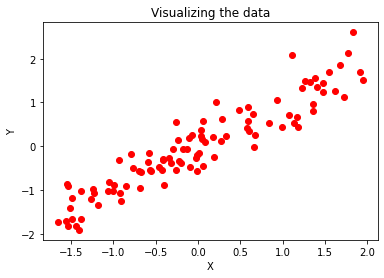

In [20]:
X,Y = linearDataset.linear_data(n_samples)
n_features = 1

## Stats Model

The statistical model is assumed to be $Y=\beta X + \mu$ where $\mu \sim N(0,1)$

No handles with labels found to put in legend.


                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.887
Model:                            OLS   Adj. R-squared (uncentered):              0.886
Method:                 Least Squares   F-statistic:                              775.8
Date:                Wed, 06 Oct 2021   Prob (F-statistic):                    1.23e-48
Time:                        18:40:57   Log-Likelihood:                         -32.952
No. Observations:                 100   AIC:                                      67.90
Df Residuals:                      99   BIC:                                      70.51
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

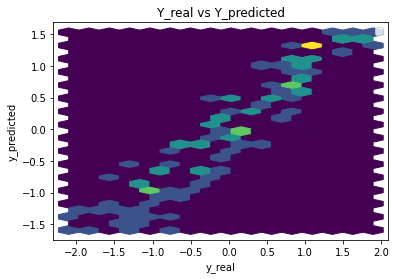

Performance Metrics
Mean Squared Error: 0.11317369320651371
Mean Absolute Error: 0.2755869272350768
Manhattan distance: 27.558692723507686
Euclidean distance: 3.3641298013975875


In [11]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

## Generator and Discriminator Networks 

**Generator Model**

A simple generator consisting of 2 input nodes and an output node

In [12]:
class Generator(nn.Module):
  def __init__(self,n_input):
    super().__init__()
    self.output = nn.Linear(n_input,1)

  def forward(self, x):
    x = self.output(x)
    return x 

**Discriminator Model**

Discriminator Model consisting of 2 input nodes,1 hidden layer and one output node.The input to the discriminator will be $(x,y_{real})$ and $(x,y_{pred})$

In [13]:
class Discriminator(nn.Module):
  def __init__(self,n_input,n_hidden):

    super().__init__()
    self.hidden = nn.Linear(n_input,n_hidden)
    self.output = nn.Linear(n_hidden,1)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.hidden(x)
    x = self.relu(x)
    x = self.output(x)
    return x 

**ABC Generators** 


1. *Correctly Specified Prior* : The 1st ABC Generator is defined as $Y = m*X + c + e$ where $m \sim N(\mu,\sigma)$ , $c=0.5$ and $e \sim N(0,1)$
2. *Misspecified Prior* : The 2nd ABC Generator is defined as $Y = 1 + m*X + c + e$ where $m \sim N(\mu,\sigma)$ , $c=0.5$ and $e \sim N(0,1)$

Here $\mu$ and $\sigma$ are parameters and can take the values $\mu = 0 , 1$ and $\sigma = 1,0.1,0.01$

In [15]:
def ABC_Generator_Correct(X,mu,sigma,batch_size,device):
    m = np.random.normal(mu,sigma)
    c = 0.5 
    X = X.numpy()
    Y = m*X + c + np.random.normal(0,1,size = batch_size)
    X = torch.from_numpy(X).reshape(batch_size,1)
    Y = torch.from_numpy(Y).reshape(batch_size,1)
    gen_input = torch.cat((X,Y),dim = 1).to(device)
    return gen_input

In [16]:
def ABC_Generator_Misspecified(X,mu,sigma,batch_size,device):
    m = np.random.normal(mu,sigma)
    c = 0.5 
    X = X.numpy()
    Y = 1 + m*X + c + np.random.normal(0,1,size = batch_size)
    X = torch.from_numpy(X).reshape(batch_size,1)
    Y = torch.from_numpy(Y).reshape(batch_size,1)
    gen_input = torch.cat((X,Y),dim = 1).to(device)
    return gen_input

## GAN Model

In [17]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
generator = Generator(n_features+1)
discriminator = Discriminator(n_features+1,hidden_nodes)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [22]:
n_epochs = 30000
batch_size = n_samples//2

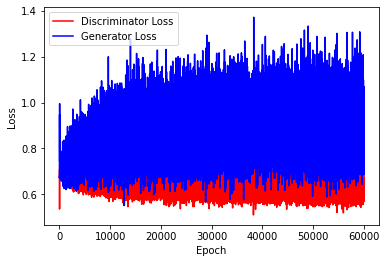

In [23]:
train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

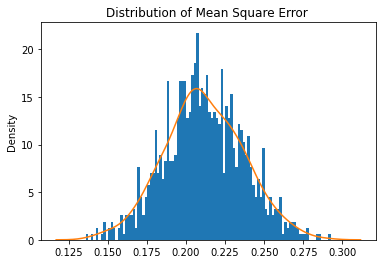

Mean Square Error: 0.2115035620689731


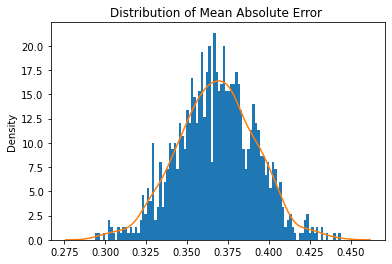

Mean Absolute Error: 0.3679251867912151


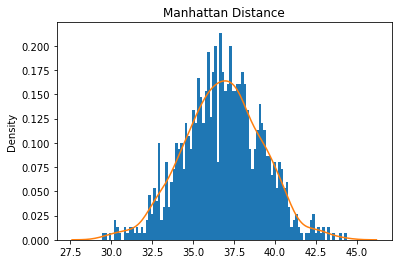

Mean Manhattan Distance: 36.79251867912151


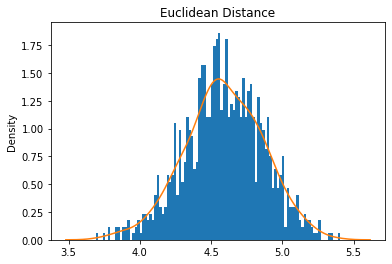

Mean Euclidean Distance: 36.79251867912151


In [24]:
train_test.test_generator(generator,real_dataset,device)

## ABC - GAN Model

In [41]:
gen = Generator(n_features+1)
disc = Discriminator(n_features+1,hidden_nodes)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [42]:
n_epoch_abc = 2000
batch_size = n_samples//2

In [43]:
def training_GAN(disc, gen,disc_opt,gen_opt,dataset, batch_size, n_epochs,criterion,coeff,mean,std,prior,device): 
    discriminatorLoss = []
    generatorLoss = []
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(n_epochs):

        for x_batch,y_batch in train_loader:
            y_shape = list(y_batch.size()) 
            curr_batch_size = y_shape[0] 
            y_batch = torch.reshape(y_batch,(curr_batch_size,1)) 

            #Create the labels  
            real_labels = torch.ones(curr_batch_size,1).to(device)
            fake_labels = torch.zeros(curr_batch_size,1).to(device)

            #------------------------
            #Update the discriminator
            #------------------------
            disc_opt.zero_grad() 

            #Get discriminator loss for real data 
            inputs_real = torch.cat((x_batch,y_batch),dim=1).to(device) 
            disc_real_pred = disc(inputs_real)
            disc_real_loss = criterion(disc_real_pred,real_labels)

            #Get discriminator loss for fake data
            gen_input = ABC_Generator_Misspecified(x_batch,mean,std,curr_batch_size,device)
            if(prior == 0):
                gen_input =  ABC_Generator_Correct(x_batch,mean,std,curr_batch_size,device)
            generated_y = gen(gen_input)  
            x_batch = x_batch.to(device)
            inputs_fake = torch.cat((x_batch,generated_y),dim=1).to(device) 
            x_batch = x_batch.detach().cpu()
            disc_fake_pred = disc(inputs_fake) 
            disc_fake_loss = criterion(disc_fake_pred,fake_labels) 

            #Get the discriminator loss 
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            discriminatorLoss.append(disc_loss.item())

            # Update gradients
            disc_loss.backward(retain_graph=True)
            # Update optimizer
            disc_opt.step()

            #------------------------
            #Update the Generator 
            #------------------------
            gen_opt.zero_grad() 

            #Generate input to generator using ABC pre-generator 
            gen_input =  ABC_pre_generator(x_batch,coeff,variance,mean,device)
            generated_y = gen(gen_input) 
            x_batch = x_batch.to(device)
            inputs_fake = torch.cat((x_batch,generated_y),dim=1).to(device)
            x_batch = x_batch.detach().cpu()
            disc_fake_pred = disc(inputs_fake)

            gen_loss = criterion(disc_fake_pred,real_labels)
            generatorLoss.append(gen_loss.item())

            #Update gradients 
            gen_loss.backward()
            #Update optimizer 
            gen_opt.step()

    #Plotting the Discriminator and Generator Loss 
    plt.plot(discriminatorLoss,color = "red",label="Discriminator Loss")
    plt.plot(generatorLoss,color="blue",label ="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
def test_generator(gen,dataset,coeff,w,std,prior,device):
    test_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    mse=[]
    mae=[]
    distp1 = []
    distp2 = []
    for epoch in range(1000):
        for x_batch, y_batch in test_loader:
            gen_input =  ABC_Generator_Misspecified(x_batch,w,std,len(dataset),device)
            if(prior == 0):
                gen_input =  ABC_Generator_Correct(x_batch,w,std,len(dataset),device)
            generated_y = gen(gen_input) 
            generated_y = generated_y.cpu().detach()
            generated_data = torch.reshape(generated_y,(-1,))
            gen_data = generated_data.numpy().reshape(1,len(dataset)).tolist()
            real_data = y_batch.numpy().reshape(1,len(dataset)).tolist()
            #Plot the data 
            if(epoch%200==0):
                gen_data1 = generated_data.numpy().tolist()
                real_data1 = y_batch.numpy().tolist()
                plt.hexbin(real_data1,gen_data1,gridsize=(15,15))
                plt.xlabel("Y")
                plt.ylabel("Y_Pred")
                plt.show()
            meanSquaredError = mean_squared_error(real_data,gen_data)
            meanAbsoluteError = mean_absolute_error(real_data, gen_data)
            mse.append(meanSquaredError)
            mae.append(meanAbsoluteError)
            dist1 = minkowski_distance(np.array(real_data)[0],np.array(gen_data)[0], 1)
            dist2 = minkowski_distance(np.array(real_data)[0],np.array(gen_data)[0], 2)
            distp1.append(dist1)
            distp2.append(dist2)

    #Distribution of Metrics 
    #Mean Squared Error 
    n,x,_=plt.hist(mse,bins=100,density=True)
    plt.title("Distribution of Mean Square Error ")
    sns.distplot(mse,hist=False)
    plt.show()
    print("Mean Square Error:",mean(mse))

    #Mean Absolute Error 
    n,x,_=plt.hist(mae,bins=100,density=True)
    plt.title("Distribution of Mean Absolute Error ")
    sns.distplot(mae,hist=False)
    plt.show()
    print("Mean Absolute Error:",mean(mae))

    #Minkowski Distance 1st Order 
    n,x,_=plt.hist(distp1,bins=100,density=True)
    plt.title("Manhattan Distance")
    sns.distplot(distp1,hist=False)
    print("Mean Manhattan Distance:",mean(distp1))
    plt.show()

    #Minkowski Distance 2nd Order 
    n,x,_=plt.hist(distp2,bins=100,density=True)
    plt.title("Euclidean Distance")
    sns.distplot(distp2,hist=False)
    print("Mean Euclidean Distance:",mean(distp2))
    plt.show()    

In [44]:
training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epoch_abc,criterion,coeff,mean,std,prior,device)

RuntimeError: shape '[50, 1]' is invalid for input of size 2500

In [ ]:
test_generator(gen,real_dataset,coeff,mean,std,prior,device)

### Sanity Check 

We plot the discriminator output vs the noise in the input to verify that the discriminator functions correctly. We expect that discriminator output and noise are inversely proportional

In [ ]:
sanityChecks.discProbVsError(real_dataset,disc,device)

### Visualization of Trained GAN Generator

In [ ]:
for name, param in gen.named_parameters():
    print(name,param)